In [1]:
# imports 
import emp_preprocessing as ep
import emp_fake_data as ef
import emp_metrics as em
import networkx as nx
import functions as fct
import numpy as np
import pandas as pd
import parameters as par
import os
import graphics as gx
import data_mapping as dm

# parameters
path = "./results/empirical_results/"
plot_period=1000

# 1 data preprocessing

## 1.1  load input data

In [2]:
# # opt 1: get the mmsr exposure view (prepared by NA)
# df_exposures = pd.read_stata("path-to-stata") # ajouter le path

# opt 2: get df_mmsr secured (used for transaction and exposure view)
df_mmsr_secured = pd.read_stata("path-to-stata") # ajouter le path

# get df_mmsr unsecured (used for deposits time series)
df_mmsr_unsecured = pd.read_stata("path-to-stata") # ajouter le path

# build fake finrep data (used for accounting view)
df_finrep = pd.read_stata("path-to-stata") # ajouter le path
df_finrep.rename(columns=dm.dic_finrep_columns, inplace=True) # change the columns names 

## 1.2 build fake data

In [2]:
nb_lines = int(1e3) # 1 million lines

# # opt 1: get the mmsr exposure view (prepared by NA)
# df_exposures = ef.get_df_exposures(lines=int(1e5),freq="5h")

# opt 2: get df_mmsr secured (used for transaction and exposure view)
df_mmsr_secured = ef.get_df_mmsr_secured(nb_tran=nb_lines,holidays=dm.holidays)

# get df_mmsr unsecured (used for deposits time series)
df_mmsr_unsecured = ef.get_df_mmsr_unsecured(nb_tran=nb_lines,freq="10min")

# build fake finrep data (used for accounting view)
df_finrep = ef.get_df_finrep()

/mnt/live/user/vlecoz/Secured_interbank_network/emp_fake_data.py:73: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  df_evergreen["trade_date"] + row * bbday
/mnt/live/user/vlecoz/Secured_interbank_network/emp_fake_data.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_evergreen["trade_date"] = (
/mnt/live/user/vlecoz/Secured_interbank_network/emp_fake_data.py:76: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  df_evergreen["maturity_date"] + row * bbday
/mnt/live/user/vlecoz/Secured_interbank_network/emp_fake_data.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

## 1.3 preprocessing

**MMSR reporting instructions for evergreen repos**

The reporting of evergreen repos is defined by the MMSR reporting instruction, paragraph 3.1 https://www.ecb.europa.eu/stats/money/mmss/shared/files/MMSR-Reporting_instructions.pdf

Evergreen are reported with the notice period defined as the maturity date and rolled over every day (reporting a new line in MMSR each day) until the product is cancelled.

To detect an evergreen we flag all transactions that are repeted across several days with the exact same counterparties, nominal amount and tenor.

In [3]:
# data anonymization 
ep.anonymize(df_mmsr_secured,df_mmsr_unsecured,df_finrep, path=path)

# # opt 1: get dic reverse repo exp adj history from exposure (prepared by NA)
# dic_rev_repo_exp_adj = ep.get_dic_rev_repo_exp_adj_from_exposures(df_exposures=df_exposures,path=path, plot_period=plot_period)

# opt 2: get dic reverse repo exp adj history directly from mmsr
df_mmsr_secured_clean = ep.get_df_mmsr_secured_clean(df_mmsr_secured,holidays=dm.holidays, path=path, compute_tenor=True)
dic_rev_repo_exp_adj = ep.get_dic_rev_repo_exp_adj_from_mmsr_secured_clean(df_mmsr_secured_clean,path=path, plot_period=plot_period)

# get aggregated adjency matrices
dic_arr_binary_adj = ep.get_dic_arr_binary_adj(dic_rev_repo_exp_adj=dic_rev_repo_exp_adj,path=path, plot_period=plot_period)

# get df_rev_repo_trans
df_rev_repo_trans = ep.get_df_rev_repo_trans(df_mmsr_secured_clean, path=path)

# get dic dashed trajectory 
df_finrep_clean = ep.get_df_finrep_clean(df_finrep, path=path)
dic_dashed_trajectory = ep.get_dic_dashed_trajectory(df_finrep_clean,path=path)

get df_mmsr_secured_clean
get dic_rev_repo_exp_adj from df_mmsr_secured_clean


100%|██████████| 632/632 [00:04<00:00, 128.45it/s]


get dic_arr_binary_adj
get dic_dashed_trajectory


In [4]:
# load input data
df_mmsr_secured_clean, df_mmsr_unsecured, df_finrep_clean = ep.load_input_data(path=path)

# pickle (faster)
dic_arr_binary_adj = ep.load_dic_arr_binary_adj(path=path)
dic_rev_repo_exp_adj = ep.load_dic_rev_repo_exp_adj(path=path)
dic_dashed_trajectory = ep.load_dic_dashed_trajectory(path=path)
df_rev_repo_trans = pd.read_csv(f"{path}pickle/df_rev_repo_trans.csv", index_col=0)

# 2 metrics measurement

In [5]:
os.makedirs(f"{path}accounting_view/", exist_ok=True)

### 2.1.2 accounting items

#### A - static, distribution across banks, at several point in time 

In [6]:
days = list(dic_rev_repo_exp_adj.keys())
plot_days = fct.list_intersection(days, dic_dashed_trajectory.keys())
bank_items = list(dic_dashed_trajectory.values())[0].columns

# get df_powerlaw
df_powerlaw = em.get_powerlaw(
            dic_dashed_trajectory=dic_dashed_trajectory,
            days=days,
            plot_days=plot_days,
            plot_period=plot_period,
            path=f"{path}accounting_view/power_law/"
        )

# plot each powerlaw charts 
gx.plot_powerlaw(
            df_network_trajectory=df_powerlaw,
            days=days,
            plot_period=plot_period,
            path=f"{path}accounting_view/",
            plot_days=plot_days,
        )

# plot p-values across time 
gx.plot_network_trajectory(
                df=df_powerlaw,
                cols=[f"powerlaw p-value {bank_item}"  for bank_item in bank_items],
                file_name=f"{path}accounting_view/power_law/powerlaw_pvalue.pdf",
            )

# plot alpha of power laws across time 
gx.plot_network_trajectory(
                df=df_powerlaw,
                cols=[f"powerlaw alpha {bank_item}"  for bank_item in bank_items],
                file_name=f"{path}accounting_view/power_law/powerlaw_alpha.pdf",
            )

run power law tests


Calculating best minimal value for power law fit
/mnt/live/user/vlecoz/conda_env/money_markets/lib/python3.8/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /
Calculating best minimal value for power law fit
/mnt/live/user/vlecoz/conda_env/money_markets/lib/python3.8/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power 

#### B - dynamic, distribution across time

In [7]:
# distribution of deposits relative variation across time for each single bank
df_deposits_variations_by_bank = ep.get_df_deposits_variations_by_bank(df_mmsr_unsecured, dic_dashed_trajectory, f"{path}/accounting_view/deposits/")

df = df_deposits_variations_by_bank[df_deposits_variations_by_bank>0]
em.run_n_plot_powerlaw(df,f"{path}accounting_view/deposits/per_bank/positive/")

df = -df_deposits_variations_by_bank[df_deposits_variations_by_bank<0]
em.run_n_plot_powerlaw(df,f"{path}accounting_view/deposits/per_bank/negative/")

get df_deposits_variations_by_bank


Calculating best minimal value for power law fit
/mnt/live/user/vlecoz/conda_env/money_markets/lib/python3.8/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /
Calculating best minimal value for power law fit
/mnt/live/user/vlecoz/conda_env/money_markets/lib/python3.8/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /
Calculating best minimal value for power law fit
/mnt/live/user/vlecoz/conda_env/money_markets/lib/python3.8/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /
Calculating best minimal value for power law fit
/mnt/live/user/vlecoz/conda_env/money_markets/lib/python3.8/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /
Calculating best minimal value for power law fit
/mnt/live/user/vlecoz/conda_env/money_markets/lib/python3.8/site-packages/powerlaw.py:699: RuntimeWarning: inva

#### C - mixed view across time and banks

In [8]:
# distribution of deposits relative variation across time for each single bank
df_mmsr_unsecured = ef.get_df_mmsr_unsecured(10000,freq="10min")
df_deposits_variations = ep.get_df_deposits_variation(df_mmsr_unsecured, dic_dashed_trajectory, f"{path}/accounting_view/deposits/")

df = df_deposits_variations[df_deposits_variations>0]
em.run_n_plot_powerlaw(df,f"{path}accounting_view/deposits/positive/")

df = -df_deposits_variations[df_deposits_variations<0]
em.run_n_plot_powerlaw(df,f"{path}accounting_view/deposits/negative/")

get df_deposits_variation


## 2.2. exposure view

In [9]:
os.makedirs(f"{path}exposure_view/", exist_ok=True)

### 2.2.1 jaccard

In [10]:
days = list(dic_rev_repo_exp_adj.keys())

# get jaccard
df_jaccard = em.get_rev_repo_exposure_stats(dic_arr_binary_adj, days, path=path)
gx.plot_network_trajectory(
            df=df_jaccard,
            cols=df_jaccard.columns,
            file_name=f"{path}exposure_view/jaccard_index.pdf")

get jaccard


  0%|          | 0/6098 [00:00<?, ?it/s]/mnt/live/user/vlecoz/Secured_interbank_network/emp_metrics.py:31: RuntimeWarning: invalid value encountered in long_scalars
  np.logical_and(
100%|██████████| 6098/6098 [00:01<00:00, 4321.93it/s]


### 2.2.2 density

In [11]:
days = list(dic_rev_repo_exp_adj.keys())

# get density
df_density = em.get_density(dic_arr_binary_adj, days, path=path)
gx.plot_network_trajectory(
            df=df_density,
            cols=df_density.columns,
            file_name=f"{path}exposure_view/network_density.pdf",
        )

get density


100%|██████████| 6098/6098 [00:01<00:00, 4399.35it/s]


### 2.2.3 degree distribution  (static)

In [12]:
days = list(dic_rev_repo_exp_adj.keys())

# get degree distribution
dic_in_degree, dic_out_degree, dic_degree = em.get_degree_distribution(dic_arr_binary_adj, path=f"{path}exposure_view/degree_distribution/")
gx.plot_degree_distribution(dic_in_degree,
    dic_out_degree,
    days,
    plot_period,
    f"{path}exposure_view/degree_distribution/")


get degree distribution


100%|██████████| 6099/6099 [00:01<00:00, 3742.20it/s]


### 2.2.4 degree stats

In [13]:
days = list(dic_rev_repo_exp_adj.keys())

# get av. degree
df_degree_stats = em.get_degree_stats(dic_degree, days, path=path)
gx.plot_network_trajectory(
            df=df_degree_stats,
            cols=df_degree_stats.columns,
            file_name=f"{path}exposure_view/degree_stats.pdf",
        )

get degree stats


100%|██████████| 6098/6098 [00:04<00:00, 1324.00it/s]


### 2.2.5 degree per asset

In [14]:
days = list(dic_rev_repo_exp_adj.keys())
bank_ids = list(dic_rev_repo_exp_adj.values())[0].index

# select the days and banks (common between the 2 lists)
finrep_days = list(df_finrep_clean["date"])
finrep_bank_ids = list(set(df_finrep_clean["lei"]))
plot_days = fct.list_intersection(days, finrep_days)

# plot
gx.plot_degree_per_asset(
    dic_dashed_trajectory,
    dic_degree,
    bank_ids,
    days,
    plot_period,
    f"{path}exposure_view/degree_per_asset/",
    plot_days=plot_days,
    finrep_bank_ids=finrep_bank_ids)

### 2.2.6 network plots (static)

In [15]:
days = list(dic_rev_repo_exp_adj.keys())
bank_ids = list(list(dic_rev_repo_exp_adj.values())[0].index)
arr_rev_repo_exp_adj = ep.convert_dic_to_array(dic_rev_repo_exp_adj)
plot_days = fct.list_intersection(days, dic_dashed_trajectory.keys())

# plot the reverse repo network
gx.plot_weighted_adj_network(
    arr_rev_repo_exp_adj,
    dic_dashed_trajectory,
    days,
    plot_period,
    f"{path}exposure_view/weighted_adj_network/",
    "reverse repo",
    bank_ids=bank_ids,
    plot_days=plot_days,
)

### 2.2.6 core periphery (static)

In [16]:
arr_rev_repo_exp_adj = ep.convert_dic_to_array(dic_rev_repo_exp_adj)
days = list(dic_rev_repo_exp_adj.keys())

# get df_cpnet
df_cpnet = em.get_cpnet(
                dic_arr_binary_adj=dic_arr_binary_adj,
                arr_rev_repo_exp_adj=arr_rev_repo_exp_adj,
                days=days,
                plot_period=plot_period,
                path=f"{path}exposure_view/core-periphery/",
            )

# Plot the core-periphery struture
gx.plot_cpnet(
                df_network_trajectory=df_cpnet,
                dic_arr_binary_adj=dic_arr_binary_adj,
                arr_rev_repo_exp_adj=arr_rev_repo_exp_adj,
                days=days,
                plot_period=plot_period,
                path=f"{path}exposure_view/",
            )

# # read csv (faster)
# df_cpnet = pd.read_csv(f"{path}exposure_view/core-periphery/df_cpnet.csv", index_col=0)
# df_cpnet.index = pd.to_datetime(df_cpnet.index)

# plot the time evolution of p-values for each aggregation level
for fig in par.figs_cpnet_pvalues:
    gx.plot_network_trajectory(
            df=df_cpnet,
            cols=fig[1],
            file_name=f"{path}{fig[0]}.pdf",
        )

run core-periphery tests
core-periphery tests using the KM_ER approach
test on day 2000-02-04 00:00:00
test on day 2004-01-08 00:00:00


  6%|▌         | 6/100 [00:00<00:00, 364.24it/s]


test on day 2007-11-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 436.71it/s]


test on day 2011-10-24 00:00:00
test on day 2015-09-23 00:00:00


  7%|▋         | 7/100 [00:00<00:00, 453.87it/s]


test on day 2019-08-21 00:00:00
test on day 2023-07-13 00:00:00


 22%|██▏       | 22/100 [00:00<00:00, 488.93it/s]


test on day 2023-11-28 00:00:00


 13%|█▎        | 13/100 [00:00<00:00, 481.83it/s]


core-periphery tests using the KM_config approach
test on day 2000-02-04 00:00:00
test on day 2004-01-08 00:00:00


  4%|▍         | 4/100 [00:00<00:00, 356.12it/s]


test on day 2007-11-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 102.89it/s]


test on day 2011-10-24 00:00:00
test on day 2015-09-23 00:00:00


  5%|▌         | 5/100 [00:00<00:00, 441.65it/s]


test on day 2019-08-21 00:00:00
test on day 2023-07-13 00:00:00


 20%|██        | 20/100 [00:00<00:00, 473.14it/s]


test on day 2023-11-28 00:00:00


  4%|▍         | 4/100 [00:00<00:00, 431.61it/s]


core-periphery tests using the Rombach approach
test on day 2000-02-04 00:00:00


100%|██████████| 100/100 [00:01<00:00, 92.21it/s]


test on day 2004-01-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 516.64it/s]


test on day 2007-11-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 932.87it/s]


test on day 2011-10-24 00:00:00


100%|██████████| 100/100 [00:01<00:00, 92.53it/s]


test on day 2015-09-23 00:00:00


100%|██████████| 100/100 [00:00<00:00, 491.89it/s]


test on day 2019-08-21 00:00:00


100%|██████████| 100/100 [00:01<00:00, 92.57it/s]


test on day 2023-07-13 00:00:00


100%|██████████| 100/100 [00:00<00:00, 254.60it/s]


test on day 2023-11-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 432.24it/s]


core-periphery tests using the Rossa approach
test on day 2000-02-04 00:00:00


100%|██████████| 100/100 [00:00<00:00, 411.70it/s]


test on day 2004-01-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 397.73it/s]


test on day 2007-11-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 396.24it/s]


test on day 2011-10-24 00:00:00


100%|██████████| 100/100 [00:00<00:00, 416.15it/s]


test on day 2015-09-23 00:00:00


100%|██████████| 100/100 [00:00<00:00, 400.94it/s]


test on day 2019-08-21 00:00:00


100%|██████████| 100/100 [00:00<00:00, 413.81it/s]


test on day 2023-07-13 00:00:00


100%|██████████| 100/100 [00:00<00:00, 408.26it/s]


test on day 2023-11-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 412.79it/s]


core-periphery tests using the LapCore approach
test on day 2000-02-04 00:00:00


100%|██████████| 100/100 [00:00<00:00, 331.48it/s]


test on day 2004-01-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 313.52it/s]


test on day 2007-11-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 312.31it/s]


test on day 2011-10-24 00:00:00


100%|██████████| 100/100 [00:00<00:00, 328.86it/s]


test on day 2015-09-23 00:00:00


100%|██████████| 100/100 [00:00<00:00, 316.73it/s]


test on day 2019-08-21 00:00:00


100%|██████████| 100/100 [00:00<00:00, 327.90it/s]


test on day 2023-07-13 00:00:00


100%|██████████| 100/100 [00:00<00:00, 311.55it/s]


test on day 2023-11-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 311.35it/s]


core-periphery tests using the LapSgnCore approach
test on day 2000-02-04 00:00:00


100%|██████████| 100/100 [00:00<00:00, 549.12it/s]


test on day 2004-01-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 514.17it/s]


test on day 2007-11-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 508.93it/s]


test on day 2011-10-24 00:00:00


100%|██████████| 100/100 [00:00<00:00, 550.57it/s]


test on day 2015-09-23 00:00:00


100%|██████████| 100/100 [00:00<00:00, 512.64it/s]


test on day 2019-08-21 00:00:00


100%|██████████| 100/100 [00:00<00:00, 551.75it/s]


test on day 2023-07-13 00:00:00


100%|██████████| 100/100 [00:00<00:00, 520.59it/s]


test on day 2023-11-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 525.28it/s]


core-periphery tests using the LowRankCore approach
test on day 2000-02-04 00:00:00


100%|██████████| 100/100 [00:00<00:00, 347.64it/s]


test on day 2004-01-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 326.31it/s]


test on day 2007-11-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 326.04it/s]


test on day 2011-10-24 00:00:00


100%|██████████| 100/100 [00:00<00:00, 345.99it/s]


test on day 2015-09-23 00:00:00


100%|██████████| 100/100 [00:00<00:00, 327.46it/s]


test on day 2019-08-21 00:00:00


100%|██████████| 100/100 [00:00<00:00, 344.76it/s]


test on day 2023-07-13 00:00:00


100%|██████████| 100/100 [00:00<00:00, 326.82it/s]


test on day 2023-11-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 325.86it/s]


core-periphery tests using the MINRES approach
test on day 2000-02-04 00:00:00


100%|██████████| 100/100 [00:02<00:00, 49.31it/s]


test on day 2004-01-08 00:00:00


100%|██████████| 100/100 [00:02<00:00, 35.77it/s]


test on day 2007-11-28 00:00:00


100%|██████████| 100/100 [00:03<00:00, 27.77it/s]


test on day 2011-10-24 00:00:00


100%|██████████| 100/100 [00:02<00:00, 49.57it/s]


test on day 2015-09-23 00:00:00


100%|██████████| 100/100 [00:02<00:00, 36.77it/s]


test on day 2019-08-21 00:00:00


100%|██████████| 100/100 [00:02<00:00, 49.32it/s]


test on day 2023-07-13 00:00:00


100%|██████████| 100/100 [00:02<00:00, 37.88it/s]


test on day 2023-11-28 00:00:00


100%|██████████| 100/100 [00:02<00:00, 38.56it/s]


core-periphery tests using the Lip approach
test on day 2000-02-04 00:00:00


100%|██████████| 100/100 [00:00<00:00, 3744.51it/s]


test on day 2004-01-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2867.43it/s]


test on day 2007-11-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2809.24it/s]


test on day 2011-10-24 00:00:00


100%|██████████| 100/100 [00:00<00:00, 3752.86it/s]


test on day 2015-09-23 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2862.97it/s]


test on day 2019-08-21 00:00:00


100%|██████████| 100/100 [00:00<00:00, 3760.43it/s]


test on day 2023-07-13 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2899.42it/s]


test on day 2023-11-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2852.69it/s]


core-periphery tests using the BE approach
test on day 2000-02-04 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1705.28it/s]


test on day 2004-01-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1004.31it/s]


test on day 2007-11-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 878.68it/s]


test on day 2011-10-24 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1721.11it/s]


test on day 2015-09-23 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1004.01it/s]


test on day 2019-08-21 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1710.77it/s]


test on day 2023-07-13 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1066.19it/s]


test on day 2023-11-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1033.71it/s]


core-periphery tests using the KM_ER approach
test on day 2000-02-04 00:00:00
test on day 2004-01-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 358.90it/s]


test on day 2007-11-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 323.68it/s]


test on day 2011-10-24 00:00:00


100%|██████████| 100/100 [00:00<00:00, 411.34it/s]


test on day 2015-09-23 00:00:00


100%|██████████| 100/100 [00:00<00:00, 358.87it/s]


test on day 2019-08-21 00:00:00


100%|██████████| 100/100 [00:00<00:00, 438.62it/s]


test on day 2023-07-13 00:00:00


100%|██████████| 100/100 [00:00<00:00, 397.40it/s]


test on day 2023-11-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 374.25it/s]


core-periphery tests using the KM_config approach
test on day 2000-02-04 00:00:00
test on day 2004-01-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 117.69it/s]


test on day 2007-11-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 147.98it/s]


test on day 2011-10-24 00:00:00


100%|██████████| 100/100 [00:00<00:00, 180.08it/s]


test on day 2015-09-23 00:00:00


100%|██████████| 100/100 [00:00<00:00, 115.67it/s]


test on day 2019-08-21 00:00:00


 56%|█████▌    | 56/100 [00:00<00:00, 395.86it/s]


test on day 2023-07-13 00:00:00


100%|██████████| 100/100 [00:00<00:00, 274.24it/s]


test on day 2023-11-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 312.45it/s]


core-periphery tests using the Rombach approach
test on day 2000-02-04 00:00:00


100%|██████████| 100/100 [00:01<00:00, 91.75it/s]


test on day 2004-01-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 876.14it/s]


test on day 2007-11-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 870.52it/s]


test on day 2011-10-24 00:00:00


100%|██████████| 100/100 [00:00<00:00, 893.68it/s]


test on day 2015-09-23 00:00:00


100%|██████████| 100/100 [00:00<00:00, 872.62it/s]


test on day 2019-08-21 00:00:00


100%|██████████| 100/100 [00:00<00:00, 717.68it/s]


test on day 2023-07-13 00:00:00


100%|██████████| 100/100 [00:00<00:00, 755.85it/s]


test on day 2023-11-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 814.18it/s]


core-periphery tests using the Rossa approach
test on day 2000-02-04 00:00:00


100%|██████████| 100/100 [00:00<00:00, 403.81it/s]


test on day 2004-01-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 382.25it/s]


test on day 2007-11-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 378.84it/s]


test on day 2011-10-24 00:00:00


100%|██████████| 100/100 [00:00<00:00, 386.08it/s]


test on day 2015-09-23 00:00:00


100%|██████████| 100/100 [00:00<00:00, 381.85it/s]


test on day 2019-08-21 00:00:00


100%|██████████| 100/100 [00:00<00:00, 383.98it/s]


test on day 2023-07-13 00:00:00


100%|██████████| 100/100 [00:00<00:00, 385.00it/s]


test on day 2023-11-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 364.10it/s]


core-periphery tests using the LapCore approach
test on day 2000-02-04 00:00:00


100%|██████████| 100/100 [00:00<00:00, 308.70it/s]


test on day 2004-01-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 286.06it/s]


test on day 2007-11-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 291.88it/s]


test on day 2011-10-24 00:00:00


100%|██████████| 100/100 [00:00<00:00, 297.28it/s]


test on day 2015-09-23 00:00:00


100%|██████████| 100/100 [00:00<00:00, 293.97it/s]


test on day 2019-08-21 00:00:00


100%|██████████| 100/100 [00:00<00:00, 300.11it/s]


test on day 2023-07-13 00:00:00


100%|██████████| 100/100 [00:00<00:00, 288.00it/s]


test on day 2023-11-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 298.73it/s]


core-periphery tests using the LapSgnCore approach
test on day 2000-02-04 00:00:00


100%|██████████| 100/100 [00:00<00:00, 532.51it/s]


test on day 2004-01-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 463.05it/s]


test on day 2007-11-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 452.52it/s]


test on day 2011-10-24 00:00:00


100%|██████████| 100/100 [00:00<00:00, 468.23it/s]


test on day 2015-09-23 00:00:00


100%|██████████| 100/100 [00:00<00:00, 482.29it/s]


test on day 2019-08-21 00:00:00


100%|██████████| 100/100 [00:00<00:00, 494.21it/s]


test on day 2023-07-13 00:00:00


100%|██████████| 100/100 [00:00<00:00, 483.06it/s]


test on day 2023-11-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 461.97it/s]


core-periphery tests using the LowRankCore approach
test on day 2000-02-04 00:00:00


100%|██████████| 100/100 [00:00<00:00, 331.62it/s]


test on day 2004-01-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 304.35it/s]


test on day 2007-11-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 315.21it/s]


test on day 2011-10-24 00:00:00


100%|██████████| 100/100 [00:00<00:00, 308.48it/s]


test on day 2015-09-23 00:00:00


100%|██████████| 100/100 [00:00<00:00, 311.77it/s]


test on day 2019-08-21 00:00:00


100%|██████████| 100/100 [00:00<00:00, 313.67it/s]


test on day 2023-07-13 00:00:00


100%|██████████| 100/100 [00:00<00:00, 311.52it/s]


test on day 2023-11-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 317.85it/s]


core-periphery tests using the MINRES approach
test on day 2000-02-04 00:00:00


100%|██████████| 100/100 [00:02<00:00, 49.21it/s]


test on day 2004-01-08 00:00:00


100%|██████████| 100/100 [00:03<00:00, 32.04it/s]


test on day 2007-11-28 00:00:00


100%|██████████| 100/100 [00:02<00:00, 33.46it/s]


test on day 2011-10-24 00:00:00


100%|██████████| 100/100 [00:03<00:00, 30.40it/s]


test on day 2015-09-23 00:00:00


100%|██████████| 100/100 [00:02<00:00, 34.01it/s]


test on day 2019-08-21 00:00:00


100%|██████████| 100/100 [00:03<00:00, 31.55it/s]


test on day 2023-07-13 00:00:00


100%|██████████| 100/100 [00:02<00:00, 35.52it/s]


test on day 2023-11-28 00:00:00


100%|██████████| 100/100 [00:02<00:00, 34.08it/s]


core-periphery tests using the Lip approach
test on day 2000-02-04 00:00:00


100%|██████████| 100/100 [00:00<00:00, 3605.65it/s]


test on day 2004-01-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2540.25it/s]


test on day 2007-11-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2473.95it/s]


test on day 2011-10-24 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2630.10it/s]


test on day 2015-09-23 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2608.32it/s]


test on day 2019-08-21 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2721.17it/s]


test on day 2023-07-13 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2575.96it/s]


test on day 2023-11-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2684.37it/s]


core-periphery tests using the BE approach
test on day 2000-02-04 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1687.16it/s]


test on day 2004-01-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 855.63it/s]


test on day 2007-11-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 840.39it/s]


test on day 2011-10-24 00:00:00


100%|██████████| 100/100 [00:00<00:00, 914.65it/s]


test on day 2015-09-23 00:00:00


100%|██████████| 100/100 [00:00<00:00, 888.09it/s]


test on day 2019-08-21 00:00:00


100%|██████████| 100/100 [00:00<00:00, 966.99it/s]


test on day 2023-07-13 00:00:00


100%|██████████| 100/100 [00:00<00:00, 873.59it/s]


test on day 2023-11-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 879.59it/s]


core-periphery tests using the KM_ER approach
test on day 2000-02-04 00:00:00
test on day 2004-01-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 301.22it/s]


test on day 2007-11-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 178.17it/s]


test on day 2011-10-24 00:00:00


100%|██████████| 100/100 [00:00<00:00, 260.42it/s]


test on day 2015-09-23 00:00:00


100%|██████████| 100/100 [00:00<00:00, 252.46it/s]


test on day 2019-08-21 00:00:00


 56%|█████▌    | 56/100 [00:00<00:00, 431.20it/s]


test on day 2023-07-13 00:00:00


100%|██████████| 100/100 [00:00<00:00, 272.02it/s]


test on day 2023-11-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 286.46it/s]


core-periphery tests using the KM_config approach
test on day 2000-02-04 00:00:00
test on day 2004-01-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 104.18it/s]


test on day 2007-11-28 00:00:00


100%|██████████| 100/100 [00:01<00:00, 91.39it/s]


test on day 2011-10-24 00:00:00


100%|██████████| 100/100 [00:01<00:00, 96.95it/s]


test on day 2015-09-23 00:00:00


100%|██████████| 100/100 [00:00<00:00, 105.49it/s]


test on day 2019-08-21 00:00:00


 57%|█████▋    | 57/100 [00:00<00:00, 280.46it/s]


test on day 2023-07-13 00:00:00


100%|██████████| 100/100 [00:00<00:00, 186.80it/s]


test on day 2023-11-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 138.21it/s]


core-periphery tests using the Rombach approach
test on day 2000-02-04 00:00:00


100%|██████████| 100/100 [00:01<00:00, 92.91it/s]


test on day 2004-01-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 871.43it/s]


test on day 2007-11-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 852.09it/s]


test on day 2011-10-24 00:00:00


100%|██████████| 100/100 [00:00<00:00, 861.85it/s]


test on day 2015-09-23 00:00:00


100%|██████████| 100/100 [00:00<00:00, 862.98it/s]


test on day 2019-08-21 00:00:00


100%|██████████| 100/100 [00:00<00:00, 787.60it/s]


test on day 2023-07-13 00:00:00


100%|██████████| 100/100 [00:00<00:00, 867.81it/s]


test on day 2023-11-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 872.65it/s]


core-periphery tests using the Rossa approach
test on day 2000-02-04 00:00:00


100%|██████████| 100/100 [00:00<00:00, 406.27it/s]


test on day 2004-01-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 392.88it/s]


test on day 2007-11-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 394.57it/s]


test on day 2011-10-24 00:00:00


100%|██████████| 100/100 [00:00<00:00, 394.02it/s]


test on day 2015-09-23 00:00:00


100%|██████████| 100/100 [00:00<00:00, 389.71it/s]


test on day 2019-08-21 00:00:00


100%|██████████| 100/100 [00:00<00:00, 398.56it/s]


test on day 2023-07-13 00:00:00


100%|██████████| 100/100 [00:00<00:00, 389.50it/s]


test on day 2023-11-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 386.94it/s]


core-periphery tests using the LapCore approach
test on day 2000-02-04 00:00:00


100%|██████████| 100/100 [00:00<00:00, 326.61it/s]


test on day 2004-01-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 304.92it/s]


test on day 2007-11-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 301.52it/s]


test on day 2011-10-24 00:00:00


100%|██████████| 100/100 [00:00<00:00, 304.06it/s]


test on day 2015-09-23 00:00:00


100%|██████████| 100/100 [00:00<00:00, 303.54it/s]


test on day 2019-08-21 00:00:00


100%|██████████| 100/100 [00:00<00:00, 307.67it/s]


test on day 2023-07-13 00:00:00


100%|██████████| 100/100 [00:00<00:00, 303.14it/s]


test on day 2023-11-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 305.65it/s]


core-periphery tests using the LapSgnCore approach
test on day 2000-02-04 00:00:00


100%|██████████| 100/100 [00:00<00:00, 544.76it/s]


test on day 2004-01-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 488.67it/s]


test on day 2007-11-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 483.45it/s]


test on day 2011-10-24 00:00:00


100%|██████████| 100/100 [00:00<00:00, 486.60it/s]


test on day 2015-09-23 00:00:00


100%|██████████| 100/100 [00:00<00:00, 487.18it/s]


test on day 2019-08-21 00:00:00


100%|██████████| 100/100 [00:00<00:00, 501.89it/s]


test on day 2023-07-13 00:00:00


100%|██████████| 100/100 [00:00<00:00, 487.77it/s]


test on day 2023-11-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 490.09it/s]


core-periphery tests using the LowRankCore approach
test on day 2000-02-04 00:00:00


100%|██████████| 100/100 [00:00<00:00, 343.56it/s]


test on day 2004-01-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 321.73it/s]


test on day 2007-11-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 319.76it/s]


test on day 2011-10-24 00:00:00


100%|██████████| 100/100 [00:00<00:00, 319.67it/s]


test on day 2015-09-23 00:00:00


100%|██████████| 100/100 [00:00<00:00, 320.17it/s]


test on day 2019-08-21 00:00:00


100%|██████████| 100/100 [00:00<00:00, 322.67it/s]


test on day 2023-07-13 00:00:00


100%|██████████| 100/100 [00:00<00:00, 322.64it/s]


test on day 2023-11-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 323.55it/s]


core-periphery tests using the MINRES approach
test on day 2000-02-04 00:00:00


100%|██████████| 100/100 [00:02<00:00, 49.98it/s]


test on day 2004-01-08 00:00:00


100%|██████████| 100/100 [00:02<00:00, 36.62it/s]


test on day 2007-11-28 00:00:00


100%|██████████| 100/100 [00:02<00:00, 42.59it/s]


test on day 2011-10-24 00:00:00


100%|██████████| 100/100 [00:02<00:00, 36.26it/s]


test on day 2015-09-23 00:00:00


100%|██████████| 100/100 [00:02<00:00, 34.84it/s]


test on day 2019-08-21 00:00:00


100%|██████████| 100/100 [00:03<00:00, 33.03it/s]


test on day 2023-07-13 00:00:00


100%|██████████| 100/100 [00:02<00:00, 38.80it/s]


test on day 2023-11-28 00:00:00


100%|██████████| 100/100 [00:02<00:00, 36.53it/s]


core-periphery tests using the Lip approach
test on day 2000-02-04 00:00:00


100%|██████████| 100/100 [00:00<00:00, 3469.15it/s]


test on day 2004-01-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2503.96it/s]


test on day 2007-11-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2351.79it/s]


test on day 2011-10-24 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2465.08it/s]


test on day 2015-09-23 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2401.25it/s]


test on day 2019-08-21 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2667.49it/s]


test on day 2023-07-13 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2553.28it/s]


test on day 2023-11-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2553.22it/s]


core-periphery tests using the BE approach
test on day 2000-02-04 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1699.07it/s]


test on day 2004-01-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 825.61it/s]


test on day 2007-11-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 792.89it/s]


test on day 2011-10-24 00:00:00


100%|██████████| 100/100 [00:00<00:00, 807.12it/s]


test on day 2015-09-23 00:00:00


100%|██████████| 100/100 [00:00<00:00, 832.55it/s]


test on day 2019-08-21 00:00:00


100%|██████████| 100/100 [00:00<00:00, 962.21it/s]


test on day 2023-07-13 00:00:00


100%|██████████| 100/100 [00:00<00:00, 820.80it/s]


test on day 2023-11-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 835.29it/s]


core-periphery tests using the KM_ER approach
test on day 2000-02-04 00:00:00
test on day 2004-01-08 00:00:00


100%|██████████| 100/100 [00:01<00:00, 74.89it/s]


test on day 2007-11-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 136.27it/s]


test on day 2011-10-24 00:00:00


100%|██████████| 100/100 [00:01<00:00, 84.99it/s]


test on day 2015-09-23 00:00:00


100%|██████████| 100/100 [00:00<00:00, 113.29it/s]


test on day 2019-08-21 00:00:00


100%|██████████| 100/100 [00:00<00:00, 242.13it/s]


test on day 2023-07-13 00:00:00


100%|██████████| 100/100 [00:00<00:00, 118.62it/s]


test on day 2023-11-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 139.14it/s]


core-periphery tests using the KM_config approach
test on day 2000-02-04 00:00:00
test on day 2004-01-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 124.85it/s]


test on day 2007-11-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 100.39it/s]


test on day 2011-10-24 00:00:00


100%|██████████| 100/100 [00:01<00:00, 56.76it/s]


test on day 2015-09-23 00:00:00


100%|██████████| 100/100 [00:01<00:00, 81.95it/s]


test on day 2019-08-21 00:00:00


100%|██████████| 100/100 [00:00<00:00, 142.05it/s]


test on day 2023-07-13 00:00:00


100%|██████████| 100/100 [00:00<00:00, 152.78it/s]


test on day 2023-11-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 116.12it/s]


core-periphery tests using the Rombach approach
test on day 2000-02-04 00:00:00


100%|██████████| 100/100 [00:01<00:00, 93.25it/s]


test on day 2004-01-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 808.92it/s]


test on day 2007-11-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 822.89it/s]


test on day 2011-10-24 00:00:00


100%|██████████| 100/100 [00:00<00:00, 814.29it/s]


test on day 2015-09-23 00:00:00


100%|██████████| 100/100 [00:00<00:00, 822.62it/s]


test on day 2019-08-21 00:00:00


100%|██████████| 100/100 [00:00<00:00, 864.02it/s]


test on day 2023-07-13 00:00:00


100%|██████████| 100/100 [00:00<00:00, 817.44it/s]


test on day 2023-11-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 819.00it/s]


core-periphery tests using the Rossa approach
test on day 2000-02-04 00:00:00


100%|██████████| 100/100 [00:00<00:00, 413.27it/s]


test on day 2004-01-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 386.03it/s]


test on day 2007-11-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 369.67it/s]


test on day 2011-10-24 00:00:00


100%|██████████| 100/100 [00:00<00:00, 361.40it/s]


test on day 2015-09-23 00:00:00


100%|██████████| 100/100 [00:00<00:00, 365.28it/s]


test on day 2019-08-21 00:00:00


100%|██████████| 100/100 [00:00<00:00, 362.04it/s]


test on day 2023-07-13 00:00:00


100%|██████████| 100/100 [00:00<00:00, 356.92it/s]


test on day 2023-11-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 364.86it/s]


core-periphery tests using the LapCore approach
test on day 2000-02-04 00:00:00


100%|██████████| 100/100 [00:00<00:00, 304.95it/s]


test on day 2004-01-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 279.61it/s]


test on day 2007-11-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 281.82it/s]


test on day 2011-10-24 00:00:00


100%|██████████| 100/100 [00:00<00:00, 279.95it/s]


test on day 2015-09-23 00:00:00


100%|██████████| 100/100 [00:00<00:00, 282.23it/s]


test on day 2019-08-21 00:00:00


100%|██████████| 100/100 [00:00<00:00, 285.59it/s]


test on day 2023-07-13 00:00:00


100%|██████████| 100/100 [00:00<00:00, 279.87it/s]


test on day 2023-11-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 280.98it/s]


core-periphery tests using the LapSgnCore approach
test on day 2000-02-04 00:00:00


100%|██████████| 100/100 [00:00<00:00, 505.69it/s]


test on day 2004-01-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 447.54it/s]


test on day 2007-11-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 453.53it/s]


test on day 2011-10-24 00:00:00


100%|██████████| 100/100 [00:00<00:00, 450.24it/s]


test on day 2015-09-23 00:00:00


100%|██████████| 100/100 [00:00<00:00, 452.90it/s]


test on day 2019-08-21 00:00:00


100%|██████████| 100/100 [00:00<00:00, 458.99it/s]


test on day 2023-07-13 00:00:00


100%|██████████| 100/100 [00:00<00:00, 447.61it/s]


test on day 2023-11-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 447.05it/s]


core-periphery tests using the LowRankCore approach
test on day 2000-02-04 00:00:00


100%|██████████| 100/100 [00:00<00:00, 321.26it/s]


test on day 2004-01-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 297.66it/s]


test on day 2007-11-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 297.81it/s]


test on day 2011-10-24 00:00:00


100%|██████████| 100/100 [00:00<00:00, 297.97it/s]


test on day 2015-09-23 00:00:00


100%|██████████| 100/100 [00:00<00:00, 297.99it/s]


test on day 2019-08-21 00:00:00


100%|██████████| 100/100 [00:00<00:00, 300.42it/s]


test on day 2023-07-13 00:00:00


100%|██████████| 100/100 [00:00<00:00, 297.21it/s]


test on day 2023-11-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 297.49it/s]


core-periphery tests using the MINRES approach
test on day 2000-02-04 00:00:00


100%|██████████| 100/100 [00:02<00:00, 44.30it/s]


test on day 2004-01-08 00:00:00


100%|██████████| 100/100 [00:02<00:00, 48.70it/s]


test on day 2007-11-28 00:00:00


100%|██████████| 100/100 [00:02<00:00, 46.11it/s]


test on day 2011-10-24 00:00:00


100%|██████████| 100/100 [00:02<00:00, 46.00it/s]


test on day 2015-09-23 00:00:00


100%|██████████| 100/100 [00:02<00:00, 47.09it/s]


test on day 2019-08-21 00:00:00


100%|██████████| 100/100 [00:02<00:00, 41.33it/s]


test on day 2023-07-13 00:00:00


100%|██████████| 100/100 [00:01<00:00, 52.27it/s]


test on day 2023-11-28 00:00:00


100%|██████████| 100/100 [00:01<00:00, 54.13it/s]


core-periphery tests using the Lip approach
test on day 2000-02-04 00:00:00


100%|██████████| 100/100 [00:00<00:00, 3552.51it/s]


test on day 2004-01-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2209.23it/s]


test on day 2007-11-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2268.28it/s]


test on day 2011-10-24 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2180.20it/s]


test on day 2015-09-23 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2243.65it/s]


test on day 2019-08-21 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2432.48it/s]


test on day 2023-07-13 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2235.13it/s]


test on day 2023-11-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2216.87it/s]


core-periphery tests using the BE approach
test on day 2000-02-04 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1654.10it/s]


test on day 2004-01-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 742.24it/s]


test on day 2007-11-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 747.58it/s]


test on day 2011-10-24 00:00:00


100%|██████████| 100/100 [00:00<00:00, 724.63it/s]


test on day 2015-09-23 00:00:00


100%|██████████| 100/100 [00:00<00:00, 767.02it/s]


test on day 2019-08-21 00:00:00


100%|██████████| 100/100 [00:00<00:00, 801.67it/s]


test on day 2023-07-13 00:00:00


100%|██████████| 100/100 [00:00<00:00, 738.23it/s]


test on day 2023-11-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 750.20it/s]


core-periphery tests using the KM_ER approach
test on day 2000-02-04 00:00:00


  1%|          | 1/100 [00:00<00:00, 323.58it/s]


test on day 2004-01-08 00:00:00


 44%|████▍     | 44/100 [00:00<00:00, 439.20it/s]


test on day 2007-11-28 00:00:00


 87%|████████▋ | 87/100 [00:00<00:00, 446.03it/s]


test on day 2011-10-24 00:00:00
test on day 2015-09-23 00:00:00


  5%|▌         | 5/100 [00:00<00:00, 378.11it/s]


test on day 2019-08-21 00:00:00
test on day 2023-07-13 00:00:00


  8%|▊         | 8/100 [00:00<00:00, 427.41it/s]


test on day 2023-11-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 440.04it/s]
/mnt/live/user/vlecoz/Secured_interbank_network/emp_metrics.py:310: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_cpnet[f"{col} {algo}-{agg_period}"] = df_algo_cpnet[col]
/mnt/live/user/vlecoz/Secured_interbank_network/emp_metrics.py:310: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_cpnet[f"{col} {algo}-{agg_period}"] = df_algo_cpnet[col]
/mnt/live/user/vlecoz/Secured_interbank_network/emp_metrics.py:310: PerformanceWarning: DataFrame is highly fragmented.  This is usuall

core-periphery tests using the KM_config approach
test on day 2000-02-04 00:00:00


  2%|▏         | 2/100 [00:00<00:00, 353.88it/s]


test on day 2004-01-08 00:00:00


  2%|▏         | 2/100 [00:00<00:00, 320.11it/s]


test on day 2007-11-28 00:00:00


 16%|█▌        | 16/100 [00:00<00:00, 409.09it/s]


test on day 2011-10-24 00:00:00
test on day 2015-09-23 00:00:00


  6%|▌         | 6/100 [00:00<00:00, 422.64it/s]


test on day 2019-08-21 00:00:00
test on day 2023-07-13 00:00:00


 14%|█▍        | 14/100 [00:00<00:00, 445.69it/s]


test on day 2023-11-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 196.77it/s]
/mnt/live/user/vlecoz/Secured_interbank_network/emp_metrics.py:310: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_cpnet[f"{col} {algo}-{agg_period}"] = df_algo_cpnet[col]
/mnt/live/user/vlecoz/Secured_interbank_network/emp_metrics.py:310: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_cpnet[f"{col} {algo}-{agg_period}"] = df_algo_cpnet[col]
/mnt/live/user/vlecoz/Secured_interbank_network/emp_metrics.py:310: PerformanceWarning: DataFrame is highly fragmented.  This is usuall

core-periphery tests using the Rombach approach
test on day 2000-02-04 00:00:00


100%|██████████| 100/100 [00:00<00:00, 409.53it/s]


test on day 2004-01-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 633.24it/s]


test on day 2007-11-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 601.01it/s]


test on day 2011-10-24 00:00:00


100%|██████████| 100/100 [00:01<00:00, 92.00it/s]


test on day 2015-09-23 00:00:00


100%|██████████| 100/100 [00:00<00:00, 446.41it/s]


test on day 2019-08-21 00:00:00


100%|██████████| 100/100 [00:01<00:00, 92.24it/s]


test on day 2023-07-13 00:00:00


100%|██████████| 100/100 [00:00<00:00, 273.16it/s]


test on day 2023-11-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 924.46it/s]
/mnt/live/user/vlecoz/Secured_interbank_network/emp_metrics.py:310: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_cpnet[f"{col} {algo}-{agg_period}"] = df_algo_cpnet[col]
/mnt/live/user/vlecoz/Secured_interbank_network/emp_metrics.py:310: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_cpnet[f"{col} {algo}-{agg_period}"] = df_algo_cpnet[col]
/mnt/live/user/vlecoz/Secured_interbank_network/emp_metrics.py:310: PerformanceWarning: DataFrame is highly fragmented.  This is usuall

core-periphery tests using the Rossa approach
test on day 2000-02-04 00:00:00


100%|██████████| 100/100 [00:00<00:00, 398.02it/s]


test on day 2004-01-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 385.94it/s]


test on day 2007-11-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 386.83it/s]


test on day 2011-10-24 00:00:00


100%|██████████| 100/100 [00:00<00:00, 401.38it/s]


test on day 2015-09-23 00:00:00


100%|██████████| 100/100 [00:00<00:00, 391.32it/s]


test on day 2019-08-21 00:00:00


100%|██████████| 100/100 [00:00<00:00, 403.08it/s]


test on day 2023-07-13 00:00:00


100%|██████████| 100/100 [00:00<00:00, 396.71it/s]


test on day 2023-11-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 390.95it/s]
/mnt/live/user/vlecoz/Secured_interbank_network/emp_metrics.py:310: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_cpnet[f"{col} {algo}-{agg_period}"] = df_algo_cpnet[col]
/mnt/live/user/vlecoz/Secured_interbank_network/emp_metrics.py:310: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_cpnet[f"{col} {algo}-{agg_period}"] = df_algo_cpnet[col]
/mnt/live/user/vlecoz/Secured_interbank_network/emp_metrics.py:310: PerformanceWarning: DataFrame is highly fragmented.  This is usuall

core-periphery tests using the LapCore approach
test on day 2000-02-04 00:00:00


100%|██████████| 100/100 [00:00<00:00, 309.00it/s]


test on day 2004-01-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 308.03it/s]


test on day 2007-11-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 307.74it/s]


test on day 2011-10-24 00:00:00


100%|██████████| 100/100 [00:00<00:00, 321.86it/s]


test on day 2015-09-23 00:00:00


100%|██████████| 100/100 [00:00<00:00, 306.82it/s]


test on day 2019-08-21 00:00:00


100%|██████████| 100/100 [00:00<00:00, 324.10it/s]


test on day 2023-07-13 00:00:00


100%|██████████| 100/100 [00:00<00:00, 310.37it/s]


test on day 2023-11-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 306.38it/s]
/mnt/live/user/vlecoz/Secured_interbank_network/emp_metrics.py:310: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_cpnet[f"{col} {algo}-{agg_period}"] = df_algo_cpnet[col]
/mnt/live/user/vlecoz/Secured_interbank_network/emp_metrics.py:310: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_cpnet[f"{col} {algo}-{agg_period}"] = df_algo_cpnet[col]
/mnt/live/user/vlecoz/Secured_interbank_network/emp_metrics.py:310: PerformanceWarning: DataFrame is highly fragmented.  This is usuall

core-periphery tests using the LapSgnCore approach
test on day 2000-02-04 00:00:00


100%|██████████| 100/100 [00:00<00:00, 503.66it/s]


test on day 2004-01-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 501.49it/s]


test on day 2007-11-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 502.71it/s]


test on day 2011-10-24 00:00:00


100%|██████████| 100/100 [00:00<00:00, 543.90it/s]


test on day 2015-09-23 00:00:00


100%|██████████| 100/100 [00:00<00:00, 503.26it/s]


test on day 2019-08-21 00:00:00


100%|██████████| 100/100 [00:00<00:00, 540.67it/s]


test on day 2023-07-13 00:00:00


100%|██████████| 100/100 [00:00<00:00, 503.46it/s]


test on day 2023-11-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 501.39it/s]
/mnt/live/user/vlecoz/Secured_interbank_network/emp_metrics.py:310: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_cpnet[f"{col} {algo}-{agg_period}"] = df_algo_cpnet[col]
/mnt/live/user/vlecoz/Secured_interbank_network/emp_metrics.py:310: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_cpnet[f"{col} {algo}-{agg_period}"] = df_algo_cpnet[col]
/mnt/live/user/vlecoz/Secured_interbank_network/emp_metrics.py:310: PerformanceWarning: DataFrame is highly fragmented.  This is usuall

core-periphery tests using the LowRankCore approach
test on day 2000-02-04 00:00:00


100%|██████████| 100/100 [00:00<00:00, 317.15it/s]


test on day 2004-01-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 318.26it/s]


test on day 2007-11-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 319.04it/s]


test on day 2011-10-24 00:00:00


100%|██████████| 100/100 [00:00<00:00, 343.04it/s]


test on day 2015-09-23 00:00:00


100%|██████████| 100/100 [00:00<00:00, 323.49it/s]


test on day 2019-08-21 00:00:00


100%|██████████| 100/100 [00:00<00:00, 342.42it/s]


test on day 2023-07-13 00:00:00


100%|██████████| 100/100 [00:00<00:00, 323.71it/s]


test on day 2023-11-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 321.94it/s]
/mnt/live/user/vlecoz/Secured_interbank_network/emp_metrics.py:310: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_cpnet[f"{col} {algo}-{agg_period}"] = df_algo_cpnet[col]
/mnt/live/user/vlecoz/Secured_interbank_network/emp_metrics.py:310: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_cpnet[f"{col} {algo}-{agg_period}"] = df_algo_cpnet[col]
/mnt/live/user/vlecoz/Secured_interbank_network/emp_metrics.py:310: PerformanceWarning: DataFrame is highly fragmented.  This is usuall

core-periphery tests using the MINRES approach
test on day 2000-02-04 00:00:00


100%|██████████| 100/100 [00:02<00:00, 35.57it/s]


test on day 2004-01-08 00:00:00


100%|██████████| 100/100 [00:02<00:00, 33.80it/s]


test on day 2007-11-28 00:00:00


100%|██████████| 100/100 [00:02<00:00, 34.94it/s]


test on day 2011-10-24 00:00:00


100%|██████████| 100/100 [00:02<00:00, 49.25it/s]


test on day 2015-09-23 00:00:00


100%|██████████| 100/100 [00:02<00:00, 37.82it/s]


test on day 2019-08-21 00:00:00


100%|██████████| 100/100 [00:02<00:00, 49.28it/s]


test on day 2023-07-13 00:00:00


100%|██████████| 100/100 [00:02<00:00, 37.92it/s]


test on day 2023-11-28 00:00:00


100%|██████████| 100/100 [00:03<00:00, 30.95it/s]
/mnt/live/user/vlecoz/Secured_interbank_network/emp_metrics.py:310: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_cpnet[f"{col} {algo}-{agg_period}"] = df_algo_cpnet[col]
/mnt/live/user/vlecoz/Secured_interbank_network/emp_metrics.py:310: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_cpnet[f"{col} {algo}-{agg_period}"] = df_algo_cpnet[col]
/mnt/live/user/vlecoz/Secured_interbank_network/emp_metrics.py:310: PerformanceWarning: DataFrame is highly fragmented.  This is usually

core-periphery tests using the Lip approach
test on day 2000-02-04 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2682.12it/s]


test on day 2004-01-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2639.95it/s]


test on day 2007-11-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2671.19it/s]


test on day 2011-10-24 00:00:00


100%|██████████| 100/100 [00:00<00:00, 3651.57it/s]


test on day 2015-09-23 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2899.28it/s]


test on day 2019-08-21 00:00:00


100%|██████████| 100/100 [00:00<00:00, 3633.98it/s]


test on day 2023-07-13 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2758.87it/s]


test on day 2023-11-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2572.91it/s]
/mnt/live/user/vlecoz/Secured_interbank_network/emp_metrics.py:310: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_cpnet[f"{col} {algo}-{agg_period}"] = df_algo_cpnet[col]
/mnt/live/user/vlecoz/Secured_interbank_network/emp_metrics.py:310: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_cpnet[f"{col} {algo}-{agg_period}"] = df_algo_cpnet[col]
/mnt/live/user/vlecoz/Secured_interbank_network/emp_metrics.py:310: PerformanceWarning: DataFrame is highly fragmented.  This is usual

core-periphery tests using the BE approach
test on day 2000-02-04 00:00:00


100%|██████████| 100/100 [00:00<00:00, 952.72it/s]


test on day 2004-01-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 933.42it/s]


test on day 2007-11-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 989.43it/s]


test on day 2011-10-24 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1657.00it/s]


test on day 2015-09-23 00:00:00


100%|██████████| 100/100 [00:00<00:00, 958.63it/s]


test on day 2019-08-21 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1636.64it/s]


test on day 2023-07-13 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1000.47it/s]


test on day 2023-11-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 834.02it/s]
/mnt/live/user/vlecoz/Secured_interbank_network/emp_metrics.py:310: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_cpnet[f"{col} {algo}-{agg_period}"] = df_algo_cpnet[col]
/mnt/live/user/vlecoz/Secured_interbank_network/emp_metrics.py:310: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_cpnet[f"{col} {algo}-{agg_period}"] = df_algo_cpnet[col]
/mnt/live/user/vlecoz/Secured_interbank_network/emp_metrics.py:310: PerformanceWarning: DataFrame is highly fragmented.  This is usuall

## 2.3 transaction view

In [17]:
os.makedirs(f"{path}transaction_view/", exist_ok=True)

### 2.3.1 av network

In [18]:
days = list(dic_rev_repo_exp_adj.keys())
df_transaction_stats = em.get_transaction_stats(
            df_rev_repo_trans=df_rev_repo_trans,
            extension=" av. network",
            days=days,
            path=f"{path}transaction_view/",
        )

# plot the time evolution of the av network trans level metrics
for fig in [par.fig_repo_transactions_maturity_av_network, par.fig_repo_transactions_notional_av_network, par.fig_number_repo_transactions_av_network]:
    gx.plot_network_trajectory(
            df=df_transaction_stats,
            cols=fig[1],
            file_name=f"{path}{fig[0]}.pdf",
        )

get transaction stats av. network


100%|██████████| 6098/6098 [00:06<00:00, 963.99it/s]


# 3 tools

## 3.1 examples of density / histogram in log - log

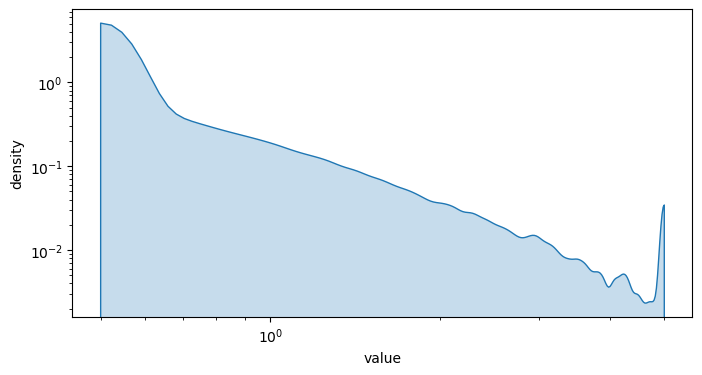

In [19]:
# Pareto law

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Generate random data
x = np.random.pareto(3,size=100000)

# Compute the absolute value and sign of the data
abs_x = np.abs(x)
sign_x = np.sign(x)

# Set up the figure
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the KDE on a log scale with the transformed data
sns.kdeplot(x.clip(0.5,5), ax=ax, cut=0, fill=True)
ax.set_xscale('log')

# Set the y-axis to log scale
ax.set_yscale('log')

# Set axis labels
ax.set_xlabel('value')
ax.set_ylabel('density')

# Show the plot
plt.show()

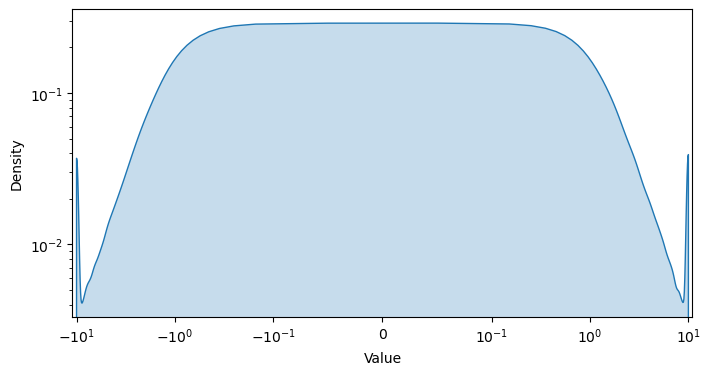

In [20]:
# student law

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Generate random data
x = np.random.standard_t(1,size=100000)

# Compute the absolute value and sign of the data
abs_x = np.abs(x)
sign_x = np.sign(x)

# Set up the figure
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the KDE on a log scale with the transformed data
sns.kdeplot(x.clip(-10,10), ax=ax, fill=True, cut=0)
ax.set_xscale('symlog', linthresh=0.1)

# Set the y-axis to log scale
ax.set_yscale('log')

# Set axis labels
ax.set_xlabel('Value')
ax.set_ylabel('Density')

# Show the plot
plt.show()

## 3.2 multiple histogram on the same plot

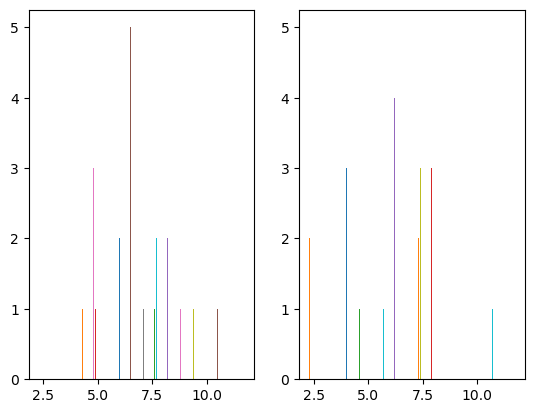

In [21]:
from matplotlib import pyplot as plt

fig, (ax1,ax2) = plt.subplots(1,2)
pos = 0
width = 0.2
for  i in range(10):
    binary_adj = np.random.randint(0,2,(10,10))
    bank_network = nx.from_numpy_array(
                binary_adj,
                parallel_edges=False,
                create_using=nx.DiGraph,
            )  # first define a networkx object.
    ar_in_degree = np.array(bank_network.in_degree())[:,1]
    hist = np.unique(ar_in_degree, return_counts=True)
    ax1.bar(hist[0] + pos, hist[1], width=0.01)
    ax2.bar(hist[0] + pos, hist[1], width=0.01)
    pos = pos +width +0.1



## 3.3 power low fitting

Calculating best minimal value for power law fit
/mnt/live/user/vlecoz/conda_env/money_markets/lib/python3.8/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /


2.477782249429199
0.409766849954752


<AxesSubplot: >

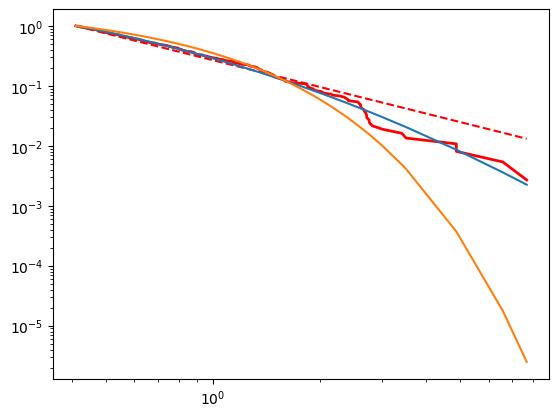

In [22]:
# fitting
import powerlaw
import numpy as np
sr_data = np.random.pareto(3,size=1000) # data can be list or numpy array
powerlaw_fit = powerlaw.Fit(sr_data)
print(powerlaw_fit.power_law.alpha)
print(powerlaw_fit.power_law.xmin)
R, p = powerlaw_fit.distribution_compare('power_law', 'exponential')
fig2 = powerlaw_fit.plot_ccdf(color = "r", linewidth = 2)
powerlaw_fit.power_law.plot_ccdf(color = "r", linestyle = "--", ax = fig2)
powerlaw_fit.lognormal.plot_ccdf(ax=fig2)
powerlaw_fit.exponential.plot_ccdf(ax=fig2)

## 3.4 build the calendar

In [23]:
from workalendar.europe import EuropeanCentralBank

# build the list of holidays
holidays = []
for year in range(2000,2025):
    holidays = holidays + EuropeanCentralBank().holidays(year)

# reformating into a list
holidays = [tuple_day[0] for tuple_day in holidays]
holidays

[datetime.date(2000, 1, 1),
 datetime.date(2000, 4, 21),
 datetime.date(2000, 4, 24),
 datetime.date(2000, 5, 1),
 datetime.date(2000, 12, 25),
 datetime.date(2000, 12, 26),
 datetime.date(2001, 1, 1),
 datetime.date(2001, 4, 13),
 datetime.date(2001, 4, 16),
 datetime.date(2001, 5, 1),
 datetime.date(2001, 12, 25),
 datetime.date(2001, 12, 26),
 datetime.date(2002, 1, 1),
 datetime.date(2002, 3, 29),
 datetime.date(2002, 4, 1),
 datetime.date(2002, 5, 1),
 datetime.date(2002, 12, 25),
 datetime.date(2002, 12, 26),
 datetime.date(2003, 1, 1),
 datetime.date(2003, 4, 18),
 datetime.date(2003, 4, 21),
 datetime.date(2003, 5, 1),
 datetime.date(2003, 12, 25),
 datetime.date(2003, 12, 26),
 datetime.date(2004, 1, 1),
 datetime.date(2004, 4, 9),
 datetime.date(2004, 4, 12),
 datetime.date(2004, 5, 1),
 datetime.date(2004, 12, 25),
 datetime.date(2004, 12, 26),
 datetime.date(2005, 1, 1),
 datetime.date(2005, 3, 25),
 datetime.date(2005, 3, 28),
 datetime.date(2005, 5, 1),
 datetime.date(200

## 3.4 quality check on the cleaning of mmsr from evergreens

In [24]:
def get_len(row):
    if isinstance(row["trans_id"], int):
        return 1 
    else:
        return len(row["trans_id"])


apply_func = lambda row: get_len(row)
df_rev_repo_trans["len"] = df_rev_repo_trans.apply(apply_func, axis=1)
df_rev_repo_trans[["len"]].value_counts()

len
3      315
25      52
40      50
20      48
2       46
35      46
30      44
10      23
1        8
dtype: int64